In [1]:
# 1/27/2022
# markstro
#
# This notebook demos: (1) compute the solar table

In [2]:
import pandas as pd
import numpy as np
import gc
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import math


In [3]:
pfn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/hru1.params"
outdir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/output/"
indir = "C:/Users/markstro/jupyter_notebooks/EC/hru1/input/"
soltab_fn = "C:/Users/markstro/jupyter_notebooks/EC/hru1/soltab_sunhrs.csv"

# Utility functions

In [4]:
# Function that will read PRMS parameter file
# Returns the contents of param file in python data structures
def read_param_file(pfn):
    line_num = 0
    vals = {}
    dims = {}
    param_dims = {}
    param_type = {}

    with open(pfn) as f:
        reading_dims = False
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1
                if line == '** Dimensions **':
                    reading_dims = True
                    line = f.readline().rstrip() 
                    line_num += 1

                if line == '** Parameters **':
                    reading_dims = False
                    break

                if reading_dims:
                    line = f.readline().rstrip()
                    line_num += 1
                    dim_name = line
                    
                    line = f.readline().rstrip() 
                    line_num += 1
                    size = line
                    
                    if dim_name in dims.keys():
                        pass
                    else:
                        dims[dim_name] = int(size)
            except:
                print("**** read parameters exception line = ", line)
                print("**** read parameters exception line_num = ", str(line_num))
                print("**** Unexpected error:", sys.exc_info()[0])

#        read params
        for line in f:
            try:
                line = line.rstrip()  # remove '\n' at end of line
                line_num += 1

                if line == "####":
                    line = f.readline().rstrip()
                    line = line.split(' ', 1)[0]  # old format parameter files have a blank (' ') and then a width format value. Strip this off.
                    param_name = line
                    line_num += 1

                    line = f.readline().rstrip()
                    line_num += 1
                    num_dims = int(line)
                    pd = [None] * num_dims
                    for ii in range(num_dims):
                        line = f.readline().rstrip()
                        pd[ii] = line
                        line_num += 1

                    param_dims[param_name] = pd

                    line = f.readline().rstrip()
                    line_num += 1
                    num_vals = int(line)
                    line = f.readline().rstrip()
                    line_num += 1
                    tp = int(line)
                    param_type[param_name] = tp

                    if tp == 2:
                        vs = np.zeros(num_vals, dtype=np.float)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = float(line)

                    elif tp == 1:
                        vs = np.zeros(num_vals, dtype=np.int)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = int(line)

                    else:
                        vs = np.zeros(num_vals, dtype=np.chararray)
                        for jj in range(num_vals):
                            line = f.readline().rstrip()
                            line_num += 1
                            vs[jj] = line

                    if num_dims == 2:
                        vs.shape = (dims[pd[1]], dims[pd[0]])

                    if param_name in vals.keys():
                        print("parameter ", param_name, " is already in ", pfn)
                    else:
                        vals[param_name] = vs

            except:
                print("read parameters exception line_num = ", str(line_num))
                print("Unexpected error:", sys.exc_info()[0])
                
    gc.collect()
    
    return (dims, vals, param_dims, param_type)

In [5]:
# I don't understand why I needed to write this function myself
# Input: datetime.Date
# Output: day of the year (aka "Julian date")
def day_of_year(d):
    N1 = math.floor(275 * d.month / 9)
    N2 = math.floor((d.month + 9) / 12)
    N3 = (1 + math.floor((d.year - 4 * math.floor(d.year / 4) + 2) / 3))
    N = N1 - (N2 * N3) + d.day - 30
    return N

# Read the simulated output into a dataframe

In [6]:
# This loops over all of the csv files in the output directory

sim_vals = None
for filename in os.listdir(outdir):
    f = os.path.join(outdir,filename)
    if os.path.isfile(f) and f.endswith('.csv'):
        varname = filename.split('.')[0]
        
        if sim_vals is None:
            sim_vals = pd.read_csv(f, names=["datestr", varname], skiprows=1)
            
        else:
            if varname != 'stats':
                df = pd.read_csv(f, names=["datestr", varname], skiprows=1)
                sim_vals = pd.merge(sim_vals, df[["datestr", varname]], on="datestr", how="left")

sim_vals["date"] = [datetime.strptime(date, '%Y-%m-%d').date() for date in sim_vals["datestr"]]
del sim_vals['datestr']

In [7]:
sim_vals.head()

,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
0,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.1863,0.0000,403.8735,78.5987,9.8522,49.7339,1,1980-10-01
1,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,0.1030,0.1030,0.0,0.1840,0.0566,396.4248,77.5987,10.8522,51.5339,1,1980-10-02
2,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,0.2629,0.2629,0.0,0.1359,0.2017,319.9297,66.2987,10.6300,51.1339,1,1980-10-03
3,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,0.0672,0.0672,0.0,0.1282,0.2280,316.8498,66.2987,7.2411,45.0339,1,1980-10-04
4,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.1083,0.2147,279.8678,63.0987,6.0744,42.9339,1,1980-10-05


In [8]:
sim_vals.tail()

,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on,date
360,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0559,0.6204,145.3992,66.1987,10.4633,50.8339,1,1981-09-26
361,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.1527,0.5382,360.0937,77.4987,11.4633,52.6339,1,1981-09-27
362,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.0864,0.5142,233.4196,69.1987,6.2411,43.2339,1,1981-09-28
363,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0437,0.5026,131.8481,59.0987,4.6855,40.4339,1,1981-09-29
364,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.0438,0.4990,130.6410,61.7987,3.8522,38.9339,1,1981-09-30


# Read the CBH forcing data into the dataframe

In [9]:
def add_date_for_PRMS_dates(df):
    df["date"] = [date(y, m, d) for y, m, d in zip(df["yr"], df["mo"], df["da"])]
    del df["yr"]
    del df["mo"]
    del df["da"]
    del df["hr"]
    del df["mi"]
    del df["se"]
    return df

In [10]:
# Read the CBH forcing inputs
cbh_vals = None
for filename in os.listdir(indir):
    f = os.path.join(indir,filename)
    if os.path.isfile(f) and f.endswith('.cbh'):
        varname = filename.split('.')[0]
        
        if cbh_vals is None:
            cbh_vals = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            cbh_vals = add_date_for_PRMS_dates(cbh_vals)

        else:
            foo = pd.read_csv(f, names=["yr", "mo", "da", "hr", "mi", "se", varname], skiprows=3, delim_whitespace=True)
            foo = add_date_for_PRMS_dates(foo)
            cbh_vals = pd.merge(cbh_vals, foo[["date", varname]], on="date", how="left")

In [11]:
cbh_vals.head()

,prcp,date,tmax,tmin
0,0.00,1979-01-01,43.6,31.0
1,0.04,1979-01-02,47.2,31.0
2,0.02,1979-01-03,53.0,34.1
3,0.49,1979-01-04,53.7,38.2
4,0.48,1979-01-05,42.9,34.9


In [12]:
cbh_vals.tail()

,prcp,date,tmax,tmin
14977,0.00,2019-12-27,50.6,34.2
14978,0.00,2019-12-28,48.3,29.1
14979,0.76,2019-12-29,41.8,29.6
14980,0.82,2019-12-30,39.6,34.6
14981,0.11,2019-12-31,43.8,35.3


In [13]:
# Read the solrad file that comes from running when print_debug is set to 5 in the control file.

In [14]:
soltab_vals = pd.read_csv(soltab_fn)

In [15]:
soltab_vals.head()

,jday,soltab_sunhrs,soltab_potsw
0,1,8.978,324.590
1,2,8.990,325.899
2,3,9.003,327.330
3,4,9.017,328.884
4,5,9.032,330.560


# Sync up the dates of the forcings and the outputs. This makes sure that all values are compared for the same date(s)

In [16]:
synced_vals = pd.merge(cbh_vals, sim_vals, on="date", how="right")

In [17]:
print(synced_vals.shape)

(365, 20)


In [18]:
synced_vals.head()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
0,0.00,1980-10-01,77.5,50.1,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.1863,0.0000,403.8735,78.5987,9.8522,49.7339,1
1,0.17,1980-10-02,76.5,51.9,0.2308,0.1039,0.1039,0.0,0.0000,0.0038,0.1030,0.1030,0.0,0.1840,0.0566,396.4248,77.5987,10.8522,51.5339,1
2,0.43,1980-10-03,65.2,51.5,0.2308,0.2629,0.2629,0.0,0.0000,0.0038,0.2629,0.2629,0.0,0.1359,0.2017,319.9297,66.2987,10.6300,51.1339,1
3,0.11,1980-10-04,65.2,45.4,0.2308,0.0672,0.0672,0.0,0.0000,0.0038,0.0672,0.0672,0.0,0.1282,0.2280,316.8498,66.2987,7.2411,45.0339,1
4,0.00,1980-10-05,62.0,43.3,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.1083,0.2147,279.8678,63.0987,6.0744,42.9339,1


In [19]:
synced_vals.tail()

,prcp,date,tmax,tmin,canopy_covden,hru_ppt,hru_rain,hru_snow,intcp_evap,intcp_stor,net_ppt,net_rain,net_snow,potet,soil_moist_tot,swrad,tmaxf,tminc,tminf,transp_on
360,0.00,1981-09-26,65.1,51.2,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0559,0.6204,145.3992,66.1987,10.4633,50.8339,1
361,0.02,1981-09-27,76.4,53.0,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.1527,0.5382,360.0937,77.4987,11.4633,52.6339,1
362,0.00,1981-09-28,68.1,43.6,0.2308,0.0000,0.0000,0.0,0.0038,0.0000,0.0000,0.0000,0.0,0.0864,0.5142,233.4196,69.1987,6.2411,43.2339,1
363,0.00,1981-09-29,58.0,40.8,0.2308,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.0,0.0437,0.5026,131.8481,59.0987,4.6855,40.4339,1
364,0.02,1981-09-30,60.7,39.3,0.2308,0.0122,0.0122,0.0,0.0000,0.0038,0.0113,0.0113,0.0,0.0438,0.4990,130.6410,61.7987,3.8522,38.9339,1


In [20]:
# Constants

ECCENTRICY = 0.01671
DEGDAY = 360.0 / 366.0
PI = 3.1415926535898
RADIANS = PI / 180.0
DEGDAYRAD = DEGDAY*RADIANS
MAX_DAYS_PER_YEAR = 366
PI_12 = 12.0 / PI
TWOPI = 2.0 * PI

In [21]:
def sun_earth():
    obliquity = np.zeros(MAX_DAYS_PER_YEAR)
    solar_declination = np.zeros(MAX_DAYS_PER_YEAR)

    for jdidx in range(MAX_DAYS_PER_YEAR):
        jday = jdidx + 1.0

    #         ! cosine of the solar zenith angle: http://www.cesm.ucar.edu/models/cesm1.0/cesm/cesmBbrowser/html_code/csm_share/shr_orb_mod.F90.html
    #         !    jday   ! Julian cal day (1.xx to 365.xx)
    #         !    lat    ! Centered latitude (radians)
    #         !    lon    ! Centered longitude (radians)
    #         !    declin ! Solar declination (radians)
    #         ! shr_orb_cosz = sin(lat)*sin(declin) - &
    #    !&              cos(lat)*cos(declin)*cos(jday*2.0_SHR_KIND_R8*pi + lon)

    #         ! Eccentricity from equation E-2 (Dingman, S. L., 1994, Physical Hydrology. Englewood Cliffs, NJ: Prentice Hall, 575 p.)
    #         ! dayangle = (2*PI*(Jday-1))/365 = DEGDAYRAD*(jddbl-1.0D0) = day angle in radians
    #         ! eccentricity = 1.00011D0 + 0.034221D0*COS(dayangle) + 0.00128D0*SIN(dayangle) + 0.000719D0*COS(2.0D0*dayangle) + 0.000077D0*SIN(2.0D0*dayangle)
    # !rsr .0172 = 2PI/365 = RADIAN_YEAR = DEGDAYRAD
    # !rsr01/2006 commented out equations from Llowd W. Swift paper 2/1976
    # !       obliquity(jd) = 1.0D0 - (0.0167D0*COS((jd-3)*0.0172D0))

        obliquity[jdidx] = 1.0 - (ECCENTRICY * math.cos((jday - 3.0) * DEGDAYRAD))

    # !       Solar_declination(jd) = 0.007D0 - (0.4067D0*COS((jd+10)*0.0172D0))
    # !       Solar_declination(jd) = ASIN(0.39785D0 * SIN( (278.9709D0+DEGDAY*jd)*RADIANS + 1.9163D0*RADIANS * SIN((356.6153D0+DEGDAY*jd)*RADIANS )) )
    #         ! hour = 12.0D0
    # !       y = DEGDAYRAD*(jddbl-1.0D0 +(hour-12.0D0)/24.0D0)

        y = DEGDAYRAD * (jday - 1.0) # assume noon
        y2 = 2.0 * y
        y3 = 3.0 * y
        solar_declination[jdidx] = 0.006918 - 0.3999120 * math.cos(y) + 0.070257 * math.sin(y) - 0.006758 * math.cos(y2) + 0.000907 * math.sin(y2) - 0.002697 * math.cos(y3) + 0.00148 * math.sin(y3)
        
    return obliquity, solar_declination

In [22]:
obliquity, solar_declination = sun_earth()

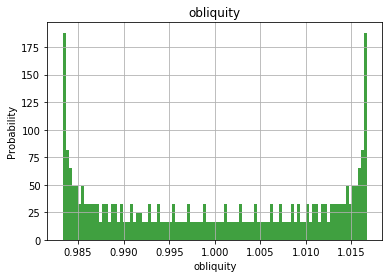

In [23]:
# the histogram of the data
n, bins, patches = plt.hist(obliquity, 100, density=True, facecolor='g', alpha=0.75)

plt.xlabel('obliquity')
plt.ylabel('Probability')
plt.title('obliquity')
plt.grid(True)
plt.show()

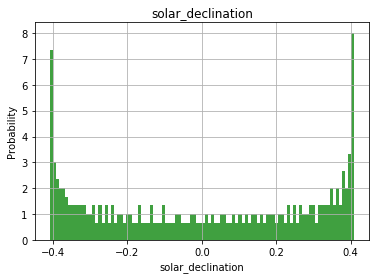

In [24]:
n, bins, patches = plt.hist(solar_declination, 100, density=True, facecolor='g', alpha=0.75)

plt.xlabel('solar_declination')
plt.ylabel('Probability')
plt.title('solar_declination')
plt.grid(True)
plt.show()

In [25]:
def compute_t(lat, solar_declination):
# !  This is the sunrise equation
# !  Lat is the latitude
# !  Solar_declination is the declination of the sun on a day
# !  T is the angle hour from the local meridian (local solar noon) to the
# !  sunrise (negative) or sunset (positive).  The Earth rotates at the angular
# !  speed of 15 degrees/hour (2 pi / 24 hour in radians) and, therefore, T/15 degress (T*24/pi
# !  in radians) gives the time of sunrise as the number of hours before the local
# !  noon, or the time of sunset as the number of hours after the local noon.
# !  Here the term local noon indicates the local time when the sun is exactly to
# !  the south or north or exactly overhead.

    tx = -math.tan(lat) * math.tan(solar_declination)

    if tx < -1.0:
        t = PI
    elif tx > 1.0:
        t = 0.0
    else:
        t = math.acos(tx)
        
    return t

In [26]:
def func3(V, W, X, Y, R1, solar_declination):
# !  This is the radian angle version of FUNC3 (eqn 6) from Swift, 1976
# !  or Lee, 1963 equation 5.
# !  func3 (R4) is potential solar radiation on the surface cal/cm2/day
# !  V (L2) latitude angle hour offset between actual and equivalent slope
# !  W (L1) latitude of the equivalent slope
# !  X (T3) hour angle of sunset on equivalent slope
# !  Y (T2) hour angle of sunrise on equivalent slope
# !  R1 solar constant for 60 minutes
# !  Solar_declination declination of sun

    f3 = R1 * PI_12 * (math.sin(solar_declination) * math.sin(W) * (X - Y)
                       + math.cos(solar_declination) * math.cos(W) * (math.sin(X + V)
                                                                      - math.sin(Y + V)))
    
    return f3

In [27]:
# In: obliquity, solar_declination, slope, aspect, latitude
# Out: cossl, soltab, sunhrs


def compute_soltab(obliquity, solar_declination, slope, aspect, latitude):
    sunhrs = np.zeros(MAX_DAYS_PER_YEAR)
    soltab = np.zeros(MAX_DAYS_PER_YEAR)
    
# ! from SWIFT (1976)
# ! x0, x1, x2 = l0, l1, l2
# ! sl = i

    sl = math.atan(slope)
    cossl = math.cos(sl)
    a = aspect * RADIANS

# ! x0 latitude of HRU
    x0 = latitude * RADIANS

# ! x1 latitude of equivalent slope
# ! This is equation 13 from Lee, 1963
    x1 = math.asin(cossl * math.sin(x0) + math.sin(sl) * math.cos(x0) * math.cos(a))

# ! d1 is the denominator of equation 12, Lee, 1963
    d1 = cossl * math.cos(x0) - math.sin(sl) * math.sin(x0) * math.cos(a)
#       IF ( abs(d1) < DNEARZERO ) d1 = DNEARZERO

# ! x2 is the difference in longitude between the location of
# ! the HRU and the equivalent horizontal surface expressed in angle hour
# ! This is equation 12 from Lee, 1963
    x2 = math.atan(math.sin(sl) * math.sin(a) / d1)
    if d1 < 0.0:
        x2 = x2 + PI
        
# ! r0 is the minute solar constant cal/cm2/min
    r0 = 2.0
# ! r0 could be 1.95 (Drummond, et al 1968)
    
    for jdidx in range(MAX_DAYS_PER_YEAR):
        d = solar_declination[jdidx]

# ! This is adjusted to express the variability of available insolation as
# ! a function of the earth-sun distance.  Lee, 1963, p 16.
# ! r1 is the hour solar constant cal/cm2/hour
# ! r0 is the minute solar constant cal/cm2/min
# ! 60.0D0 is minutes in an hour
# ! Obliquity is the obliquity of the ellipse of the earth's orbit around the sun. E
# ! is also called the radius vector of the sun (or earth) and is the ratio of
# ! the earth-sun distance on a day to the mean earth-sun distance.
# ! obliquity = ~23.439 (obliquity of sun)

        r1 = 60.0 * r0 / (obliquity[jdidx] * obliquity[jdidx])

# !  compute_t is the sunrise equation.
# !  t7 is the hour angle of sunset on the equivalent slope
# !  t6 is the hour angle of sunrise on the equivalent slope
        t = compute_t(x1, d)
        t7 = t - x2
        t6 = -t - x2

# !  compute_t is the sunrise equation.
# !  t1 is the hour angle of sunset on a hroizontal surface at the HRU
# !  t0 is the hour angle of sunrise on a hroizontal surface at the HRU
        t = compute_t(x0, d)
        t1 = t
        t0 = -t
        
# ! For HRUs that have an east or west direction component to their aspect, the
# ! longitude adjustment (moving the effective slope east or west) will cause either:
# ! (1) sunrise to be earlier than at the horizontal plane at the HRU
# ! (2) sunset to be later than at the horizontal plane at the HRU
# ! This is not possible. The if statements below check for this and adjust the
# ! sunrise/sunset angle hours on the equivalent slopes as necessary.
# !
# ! t3 is the hour angle of sunrise on the slope at the HRU
# ! t2 is the hour angle of sunset on the slope at the HRU
        if t7 > t1:
            t3 = t1
        else:
            t3 = t7
            
        if t6 < t0:
            t2 = t0
        else:
            t2 = t6

# !  solt is Swift's R4 (potential solar radiation on a sloping surface cal/cm2/day)
# !  Swift, 1976, equation 6
#
# !  sunh is the number of hours of direct sunlight (sunset minus sunrise) converted
# !  from angle hours in radians to hours (24 hours in a day divided by 2 pi radians
# !  in a day).
#         print(slope, sl, abs(sl))
        if abs(sl) == 0.0:
            solt = func3(0.0, x0, t1, t0, r1, d)
            sunh = (t1 - t0) * PI_12
#             print("jdidx =", jdidx+1, "solt =", solt, "sunh =", sunh, "x0 =", x0, "t1 =", t1, "t0 =", t0, "r1 =", r1, "d =", d)
            
        else:
            if t3 < t2:
                t2 = 0.0
                t3 = 0.0
            t6 = t6 + TWOPI
            if t6 < t1:
                solt = func3(x2, x1, t3, t2, r1, d) + func3(x2, x1, t1, t6, r1, d)
                sunh = (t3-t2+t1-t6)*PI_12
            else:
                t7 = t7 - TWOPI
                if t7 > t0:
                    solt = func3(x2, x1, t3, t2, r1, d) + func3(x2, x1, t7, t0, r1, d)
                    sunh = (t3 - t2 + t7 - t0) * PI_12
                else:
                    solt = func3(x2, x1, t3, t2, r1, d)
                    sunh = (t3 - t2) * PI_12
                    
        if solt < 0.0:
            print("soltab: jd =", jdidx+1, " solt =", solt)

        if sunh < 0.0:
            sunh = 0.0
            
        sunhrs[jdidx] = sunh
        soltab[jdidx] = solt
        
    return cossl, soltab, sunhrs

In [28]:
def soltab(obliquity, solar_declination, hru_slope, hru_aspect, hru_lat, hru_area):
    ihru = 0
        
    hru_cossl, soltab_horad_potsw, soltab_sunhrs = compute_soltab(obliquity, solar_declination, 0.0, 0.0, hru_lat[ihru])
    hru_cossl, soltab_potsw, soltab_sunhrs = compute_soltab(obliquity, solar_declination, hru_slope[ihru], hru_aspect[ihru], hru_lat[ihru])

    basin_lat = sum(hru_lat * hru_area) / sum(hru_area)
    basin_cossl, soltab_basinpotsw, basin_sunhrs = compute_soltab(obliquity, solar_declination, 0.0, 0.0, basin_lat)
        
    return soltab_sunhrs, soltab_potsw, hru_cossl, soltab_horad_potsw, soltab_basinpotsw, basin_sunhrs, basin_cossl

In [29]:
# Call soltab function and check results

params = read_param_file(pfn)
vals = params[1]
hru_slope = vals["hru_slope"]
hru_aspect = vals["hru_aspect"]
hru_lat = vals["hru_lat"]
hru_area = vals["hru_area"]
    
soltab_sunhrs, soltab_potsw, hru_cossl, soltab_horad_potsw, soltab_basinpotsw, basin_sunhrs, basin_cossl = soltab(
    obliquity, solar_declination, hru_slope, hru_aspect, hru_lat, hru_area)

# Day length soltab_sunhrs

In [30]:
jday = soltab_vals["jday"]

In [31]:
err = soltab_vals["soltab_sunhrs"] - soltab_sunhrs
print(sum(soltab_vals["soltab_sunhrs"].values), sum(soltab_sunhrs))

4359.179999999998 4361.407133415414


Text(0, 0.5, 'Error soltab_sunhrs (hours)')

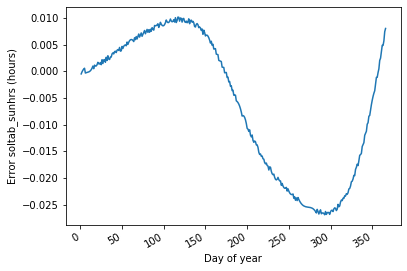

In [32]:
plt.plot(jday, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Error soltab_sunhrs (hours)")

Text(0, 0.5, 'Python computed soltab_sunhrs (hours)')

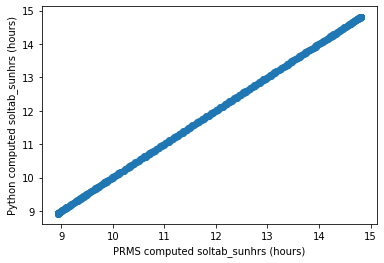

In [33]:
plt.scatter(soltab_vals["soltab_sunhrs"].values, soltab_sunhrs)
plt.xlabel("PRMS computed soltab_sunhrs (hours)")
plt.ylabel("Python computed soltab_sunhrs (hours)")

In [34]:
rerr = (soltab_vals["soltab_sunhrs"] - soltab_sunhrs) / soltab_vals["soltab_sunhrs"]

Text(0, 0.5, 'Relative error soltab_sunhrs (Unitless)')

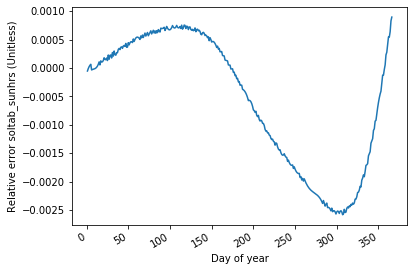

In [35]:
plt.plot(jday, rerr)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Relative error soltab_sunhrs (Unitless)")

# Clear sky solar radiation soltab_potsw

In [36]:
err = soltab_vals["soltab_potsw"] - soltab_potsw
print(sum(soltab_vals["soltab_potsw"].values), sum(soltab_potsw))

251630.80500000014 251906.55432559337


Text(0, 0.5, 'Error soltab_potsw (Langleys per day)')

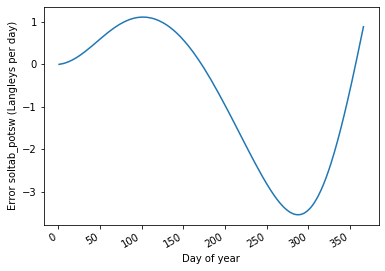

In [37]:
plt.plot(jday, err)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Error soltab_potsw (Langleys per day)")

Text(0, 0.5, 'Python computed soltab_potsw (Langleys per day)')

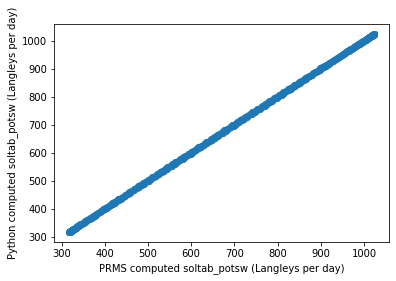

In [38]:
plt.scatter(soltab_vals["soltab_potsw"].values, soltab_potsw)
plt.xlabel("PRMS computed soltab_potsw (Langleys per day)")
plt.ylabel("Python computed soltab_potsw (Langleys per day)")

In [39]:
rerr = (soltab_vals["soltab_potsw"] - soltab_potsw) / soltab_vals["soltab_potsw"]

Text(0, 0.5, 'Relative error soltab_potsw (Unitless)')

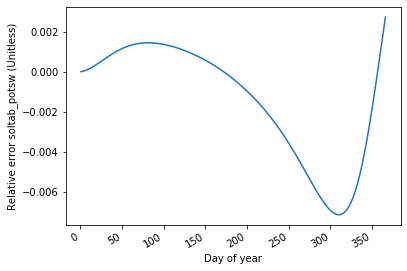

In [40]:
plt.plot(jday, rerr)
plt.xticks(rotation=30, ha='right')
plt.xlabel("Day of year")
plt.ylabel("Relative error soltab_potsw (Unitless)")